In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

from tensorflow.keras.utils import to_categorical

from medmnist import BloodMNIST

2024-05-16 11:46:58.559190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 11:46:59.935275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/toffanetto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Importing data

INPUT_N = 28

train_dataset = BloodMNIST(split="train", download=True, size=INPUT_N)

X_train_full = np.zeros([len(train_dataset), INPUT_N, INPUT_N, 3]) 

y_train_full = np.zeros([len(train_dataset), 1])

for i in range(len(train_dataset)):
    x, y_train_full[i] = train_dataset[i]
    X_train_full[i] = np.array(x)/255.0
    
i_val = int(len(train_dataset)*0.7)

X_train = X_train_full[:i_val]
y_train = y_train_full[:i_val]

X_val = X_train_full[i_val:]
y_val = y_train_full[i_val:]

print('Number of samples in train dataset: '+str(len(train_dataset)))

print('Shape of data in train dataset: '+str(X_train.shape)+" "+str(y_train.shape))

print('Shape of data in validation dataset: '+str(X_val.shape)+" "+str(y_val.shape))

test_dataset = BloodMNIST(split="test", download=True, size=INPUT_N)

X_test = np.zeros([len(test_dataset), INPUT_N, INPUT_N, 3])

y_test = np.zeros([len(test_dataset), 1])

for i in range(len(test_dataset)):
    x, y_test[i] = test_dataset[i]
    X_test[i] = np.array(x)/255.0

print('Number of samples in test dataset: '+str(len(test_dataset)))

print('Shape of data in test dataset: '+str(X_test.shape)+" "+str(y_test.shape))

classes_labels = ['Basófilos - 0', 'Eosinófilos - 1', 'Eritroblastos - 2', 'Granulócitos imaturos - 3',
                  'Linfócitos - 4', 'Monócitos - 5', 'Neutrófilos - 6', 'Plaquetas - 7']


Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist.npz
Number of samples in train dataset: 11959
Shape of data in train dataset: (8371, 28, 28, 3) (8371, 1)
Shape of data in validation dataset: (3588, 28, 28, 3) (3588, 1)
Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist.npz
Number of samples in test dataset: 3421
Shape of data in test dataset: (3421, 28, 28, 3) (3421, 1)


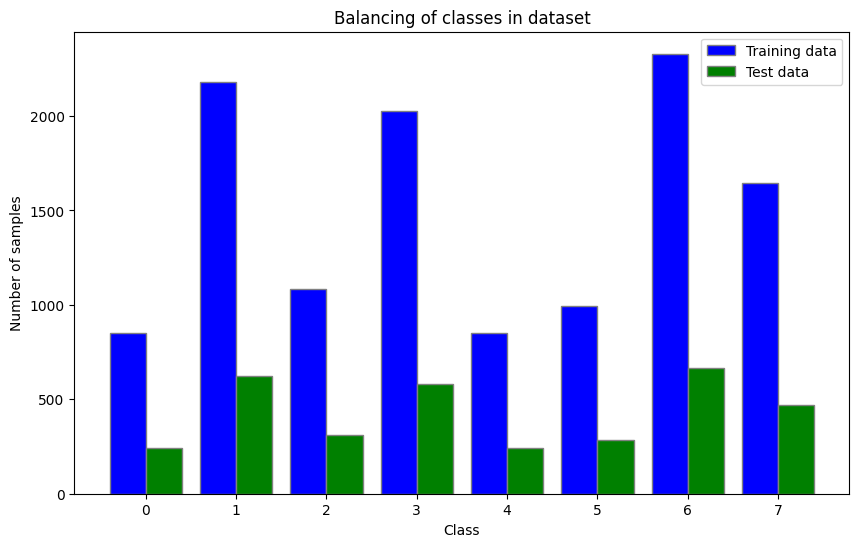

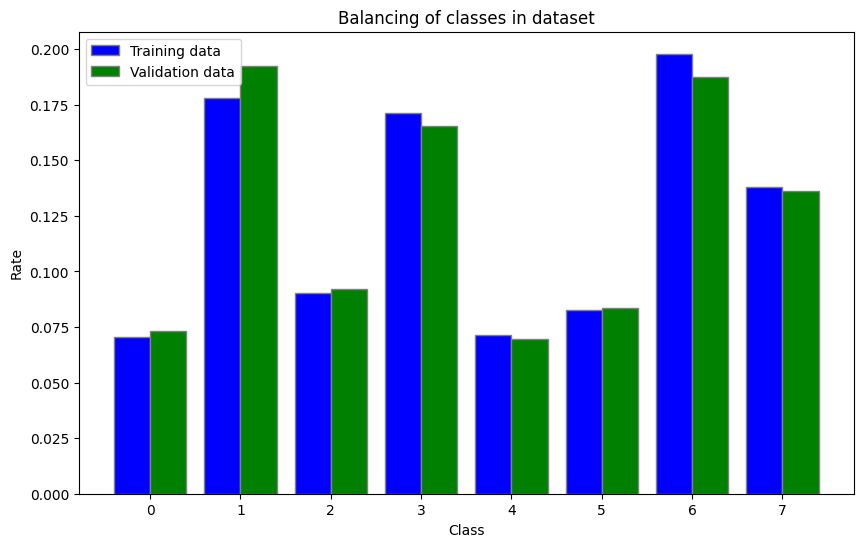

In [3]:
# Dataset balancing

train_one_hot = to_categorical(y_train_full)
test_one_hot =  to_categorical(y_test)
                                 
train_balancing = np.sum(train_one_hot, axis=0)
test_balancing = np.sum(test_one_hot, axis=0)
test_balancing_norm = test_balancing/np.sum(test_balancing, axis=0)

barWidth = 0.4

plt.figure(figsize=(10,6))
 
# Set position of bar on X axis 
br1 = np.arange(len(train_balancing)) 
br2 = [x + barWidth for x in br1] 
 
# Make the plot
plt.bar(br1, train_balancing, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Training data') 
plt.bar(br2, test_balancing, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Test data') 
 
# Adding Xticks 
plt.xlabel('Class') 
plt.ylabel('Number of samples') 
plt.xticks([r + barWidth/2 for r in range(len(train_balancing))], 
        ['0', '1', '2', '3', '4', '5', '6', '7'])
plt.title('Balancing of classes in dataset')
 
plt.legend(loc='upper right')

plt.savefig("../plot/Balancing_of_classes.pdf", format="pdf", bbox_inches="tight")

# Using holdout

train_one_hot = to_categorical(y_train)
val_one_hot =  to_categorical(y_val)
                                 
train_balancing = np.sum(train_one_hot, axis=0)
val_balancing = np.sum(val_one_hot, axis=0)

train_balancing = train_balancing/np.sum(train_balancing)
val_balancing = val_balancing/np.sum(val_balancing)

barWidth = 0.4

plt.figure(figsize=(10,6))
 
# Set position of bar on X axis 
br1 = np.arange(len(train_balancing)) 
br2 = [x + barWidth for x in br1] 
 
# Make the plot
plt.bar(br1, train_balancing, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Training data') 
plt.bar(br2, val_balancing, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Validation data') 
 
# Adding Xticks 
plt.xlabel('Class') 
plt.ylabel('Rate') 
plt.xticks([r + barWidth/2 for r in range(len(train_balancing))], 
        ['0', '1', '2', '3', '4', '5', '6', '7'])
plt.title('Balancing of classes in dataset')
 
plt.legend(loc='upper left')

plt.savefig("../plot/Balancing_of_classes_holdout.pdf", format="pdf", bbox_inches="tight")

### DenseNet-Fashion CNN Deep

- Input
- Batch Normalization
- Conv
- Dense Block
- Conv 1x1
- Pooling
- Softmax


In [4]:
def convLayer(x, n_kernels, kernel_size=1):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=kernel_size,
                               strides=1, padding="SAME")(x)
    return x

def denseBlock(x, n_kernels, repetitions):
    for _ in range(repetitions):
        y = convLayer(x, 4*n_kernels)
        y = convLayer(y, n_kernels, 3)
        x = tf.keras.layers.concatenate([x,y])
    return x

In [8]:
tf.keras.backend.clear_session()

epochs = 200

input = tf.keras.layers.Input(shape=(28, 28, 3))
x = tf.keras.layers.Conv2D(64, 7, padding="same")(input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPool2D(2, padding="same")(x)

x = denseBlock(x, 32, 6)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

output = tf.keras.layers.Dense(8, activation="softmax")(x)

model = tf.keras.models.Model(input, output)

model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │      8,320 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     36,896 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14, 14,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     12,416 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 14, 14,    │          0 │ batch_normalizat

 Total params: 351,048 (1.34 MB)

 Trainable params: 347,656 (1.33 MB)

 Non-trainable params: 3,392 (13.25 KB)

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
                optimizer="sgd",
                metrics=["accuracy"])

checkpoint_cb = keras.callbacks.ModelCheckpoint("../model/cnn_deep/cnn_densenet.weights.h5",
                                                save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb], verbose=1)

model.load_weights("../model/cnn_deep/cnn_densenet.weights.h5")

val_accuracy = max(history.history['val_accuracy'])

val_loss = history.history['val_loss'][history.history['val_accuracy'].index(val_accuracy)]

loss, accuracy = model.evaluate(X_test,y_test)

print('\n=========================')
print('accuracy on training data = '+str(accuracy))
print('=========================\n')


Epoch 1/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.5082 - loss: 1.4109 - val_accuracy: 0.1876 - val_loss: 3.8488
Epoch 2/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7778 - loss: 0.6625 - val_accuracy: 0.6653 - val_loss: 0.8684
Epoch 3/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8214 - loss: 0.5189 - val_accuracy: 0.3935 - val_loss: 2.4021
Epoch 4/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8416 - loss: 0.4458 - val_accuracy: 0.7327 - val_loss: 0.7023
Epoch 5/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8572 - loss: 0.4092 - val_accuracy: 0.2012 - val_loss: 6.6057
Epoch 6/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8622 - loss: 0.3894 - val_accuracy: 0.6711 - val_loss: 0.9325
Epoch 7/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8607 - loss: 0.3675 - val_accuracy: 0.5571 - val_loss: 1.8068
Epoch 8/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8765 - loss: 0.3413 -

(0.0, 1.0)

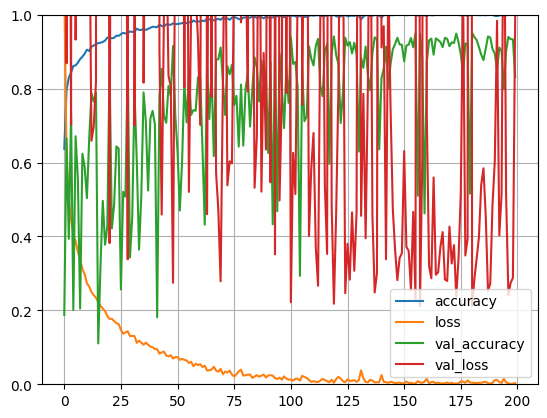

In [14]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.ylim([0,1])

In [11]:
def rateModel(y,y_hat,classes_rate):
    
    hit = np.zeros(8)
    confusion_matrix = np.zeros([8,8])
    
    for i in range(len(y)):
        confusion_matrix[y[i], y_hat[i]] += 1
        
        hit[y[i]] += 1 if y[i] == y_hat[i] else 0
            
    ba = np.average(hit/(classes_rate*len(y)))
        
    return confusion_matrix, ba

def confusionMatrixExtract(confusion_matrix):
    score = {0 : {'Precision': 0, 'Recall': 0}, 
             1 : {'Precision': 0, 'Recall': 0}, 
             2 : {'Precision': 0, 'Recall': 0},
             3 : {'Precision': 0, 'Recall': 0},
             4 : {'Precision': 0, 'Recall': 0},
             5 : {'Precision': 0, 'Recall': 0},
             6 : {'Precision': 0, 'Recall': 0},
             7 : {'Precision': 0, 'Recall': 0}}
    
    for i in range(8):
        TP = FP = FN = 0
        for j in range(8):
            TP = confusion_matrix[i][j] if i == j else TP
            FP += confusion_matrix[i][j] if i != j else 0
            FN += confusion_matrix[j][i] if i != j else 0
            
        score[i]['Precision']= TP/(TP+FP)
        score[i]['Recall']= TP/(TP+FN)
    
    return score

In [12]:
loss, accuracy = model.evaluate(X_test,y_test)

y_hat_test_ohe = model.predict_on_batch(X_test)

y_hat_test = np.argmax(y_hat_test_ohe, axis=1)

confusion_matrix, ba = rateModel(np.uint8(np.squeeze(y_test)), y_hat_test, test_balancing_norm)

score = confusionMatrixExtract(confusion_matrix)

print('confusion_matrix = \n'+str(confusion_matrix))

print('\nAccuracy = '+str(accuracy))

print('\nBA = '+str(ba)+"\n")

print("Class | Precision | Recall")
for i in range(8):
    print(str(i)+'\t'+str("{:.4f}".format(score[i]['Precision']))+'\t'+str("{:.4f}".format(score[i]['Recall'])))

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9494 - loss: 0.2252


2024-05-16 12:27:09.497105: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-16 12:27:09.497141: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-16 12:27:11.387212: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[3421,64,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3421,3,28,28]{3,2,1,0}, f32[64,3,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operati

confusion_matrix = 
[[228.   0.   0.   7.   2.   5.   2.   0.]
 [  1. 621.   0.   1.   0.   0.   1.   0.]
 [  1.   0. 304.   2.   3.   0.   0.   1.]
 [ 17.   2.  12. 504.   5.  21.  18.   0.]
 [  0.   0.   6.  14. 221.   2.   0.   0.]
 [  1.   0.   1.  24.   2. 255.   1.   0.]
 [  1.   1.   4.  13.   0.   1. 646.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 470.]]

Accuracy = 0.9497222900390625

BA = 0.9443623917935728

Class | Precision | Recall
0	0.9344	0.9157
1	0.9952	0.9952
2	0.9775	0.9297
3	0.8705	0.8920
4	0.9095	0.9485
5	0.8979	0.8979
6	0.9700	0.9671
7	1.0000	0.9979


|++  8  ++|
Predicted class: 5
     Real class: 6
Probilites for each class: 
	(5, 0.7478933)
	(6, 0.25184834)
	(1, 0.00024678113)
	(3, 9.647286e-06)
	(7, 1.9195775e-06)
	(2, 6.6977304e-09)
	(4, 4.6704933e-09)
	(0, 8.4741847e-10)



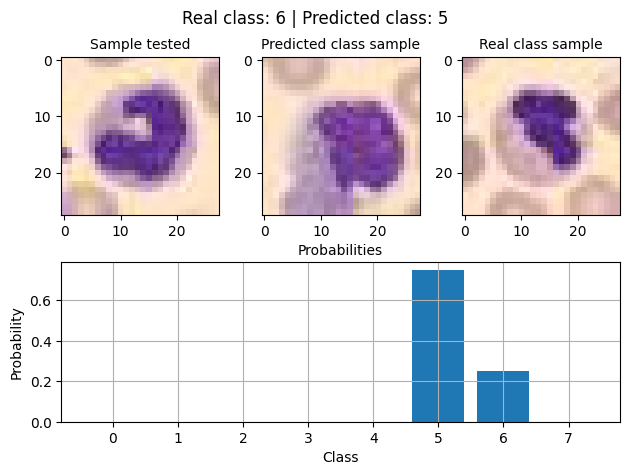

|++  35  ++|
Predicted class: 3
     Real class: 6
Probilites for each class: 
	(3, 0.96355)
	(6, 0.035303842)
	(0, 0.00071840757)
	(4, 0.00022690906)
	(5, 0.00018783422)
	(2, 7.977751e-06)
	(1, 4.751097e-06)
	(7, 3.069012e-07)



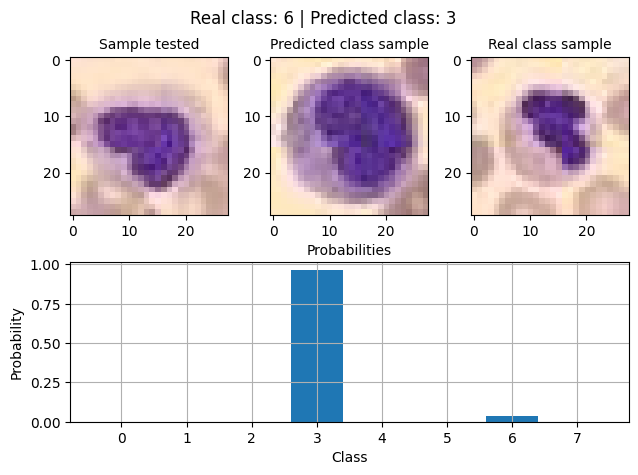

|++  62  ++|
Predicted class: 2
     Real class: 6
Probilites for each class: 
	(2, 0.9510636)
	(4, 0.04389448)
	(3, 0.0042527867)
	(6, 0.00056934654)
	(7, 0.00014830679)
	(0, 4.5855188e-05)
	(1, 2.15069e-05)
	(5, 4.168667e-06)



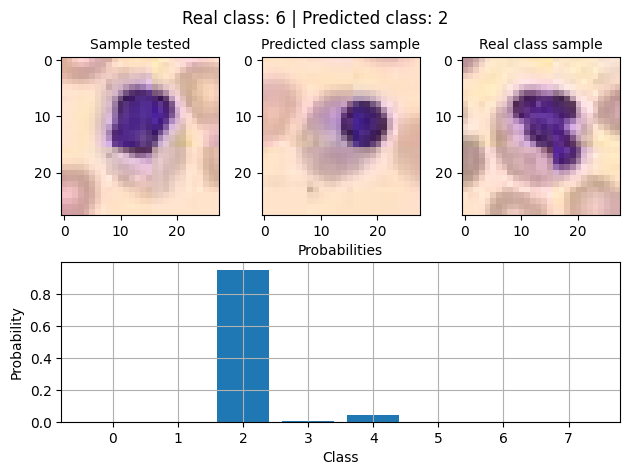

|++  259  ++|
Predicted class: 4
     Real class: 2
Probilites for each class: 
	(4, 0.52562445)
	(2, 0.36874127)
	(3, 0.10139675)
	(7, 0.0041566556)
	(0, 4.2297987e-05)
	(1, 3.813376e-05)
	(6, 5.076e-07)
	(5, 2.9615009e-08)



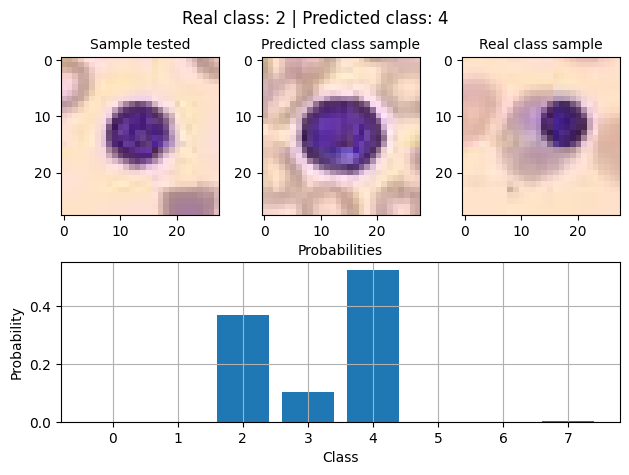

|++  187  ++|
Predicted class: 2
     Real class: 4
Probilites for each class: 
	(2, 0.7953783)
	(4, 0.16232209)
	(3, 0.04227402)
	(5, 1.51229115e-05)
	(0, 7.426757e-06)
	(1, 2.8038432e-06)
	(7, 1.6406561e-07)
	(6, 8.0905344e-10)



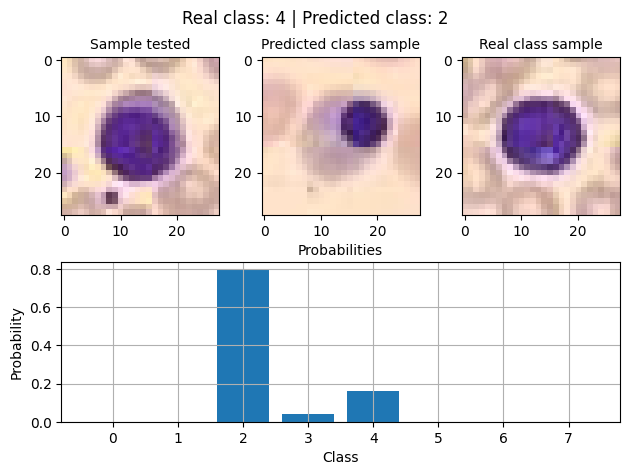

In [22]:
y_train_list = y_train[:,0].tolist()

class_samples = [y_train_list.index(i) for i in range(8)]

for i in [8, 35, 62, 259, 187]:
    if y_hat_test[i] != y_test[i]:
        print("|++  "+str(i)+"  ++|")
        print("Predicted class: "+str(y_hat_test[i]))
        print("     Real class: "+str(int(y_test[i,0])))
        prob = sorted(list(enumerate(y_hat_test_ohe[i])),key=lambda tup: tup[1], reverse=True)
        s = ""
        for j in range(8):
            s += "\t"+str(prob[j])+"\n" 
        print("Probilites for each class: \n"+s)
                
        plt.figure()        
        plt.subplot(2,3,1)
        plt.imshow(X_test[i])
        plt.title("Sample tested",fontsize=10)
        plt.subplot(2,3,2)
        plt.imshow(X_train[class_samples[y_hat_test[i]]])
        plt.title("Predicted class sample",fontsize=10)
        plt.subplot(2,3,3)
        plt.imshow(X_train[class_samples[int(y_test[i,0])]])
        plt.title("Real class sample",fontsize=10)
        plt.subplot(2,3,(4,6))
        plt.bar(x=[0, 1, 2, 3, 4, 5, 6, 7],height=y_hat_test_ohe[i])
        plt.title("Probabilities",fontsize=10)
        plt.grid()
        plt.ylabel("Probability")
        plt.xlabel("Class")
        plt.suptitle("Real class: "+str(int(y_test[i,0]))+" | Predicted class: "+str(y_hat_test[i]))
        plt.tight_layout()
        plt.savefig("../plot/cnn_deep/error_analyser_"+str(i)+".pdf", format="pdf", bbox_inches="tight")
        plt.show()